#                                                                                              深圳出租车轨迹数据分析

## I. 数据准备

In [1]:
print sc
print sqlContext

In [2]:
trackposRDD1 = sc.textFile('file:/mnt/hgfs/share/Final/I.FINAL-taxi/data/tpos.csv', use_unicode=False)
tposrdd = trackposRDD1.map(lambda x: x.split(',')).map(lambda l: [x.strip('"')for x in l])

print tposrdd.first()

['\xe7\xb2\xa4B084C5', '20', '17', '114.075714', '22.53205', '0', '9.0', '9']


### Hive-Spark每车空驶率

#### 计算公式

In [3]:
#haversine
from math import pi,sqrt,sin,cos,atan2

def distance(jd1, wd1, jd2, wd2):
    lat1 = float(wd1)
    long1 = float(jd1)
    lat2 = float(wd2)
    long2 = float(jd2)

    degree_to_rad = float(pi / 180.0)

    d_lat = (lat2 - lat1) * degree_to_rad
    d_long = (long2 - long1) * degree_to_rad

    a = pow(sin(d_lat / 2), 2) + cos(lat1 * degree_to_rad) * cos(lat2 * degree_to_rad) * pow(sin(d_long / 2), 2)
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    km = 6367 * c
    #mi = 3956 * c

    return km

In [4]:
aa = sc.parallelize((114.118347,22.574850,114.134666,22.579300))

print aa.collect()
print "方法二结果：%f" %distance(aa.collect()[0], aa.collect()[1], aa.collect()[2], aa.collect()[3])

[114.118347, 22.57485, 114.134666, 22.5793]
方法二结果：1.745968


In [5]:
#定义全局变量来报存缓存数据
pre_name = ''
pre_pos = []
pre_status = None



def rdd_dist(row):
    #mark 缓存变量
    global pre_name
    global pre_pos
    global pre_status
       
    # 格式转换( 如需)
    row[0] = row[0][3:]
    row[1] = int(row[1])
    row[2] = int(row[2])
    row[3] = float(row[3])
    row[4] = float(row[4])
    row[5] = int(row[5])
    row[6] = float(0)
    row[7] = int(row[7])
    
    #读第一行数据
    if pre_name == '':
        pre_name = row[0][1:]
        pre_pos.append(row[3])
        pre_pos.append(row[4])
        pre_status = row[5]
    
    else:
        #如果车牌和上一行一样时
        if row[0] == pre_name:
            row[6] = distance(pre_pos[0], pre_pos[1], row[3], row[4])
            if (pre_status==0 and row[5]==1):
                row[7] = 1
            elif (pre_status==1 and row[5]==0):
                row[7] = 0
            else:
                row[7] = 9
        
        #车牌不一样的时候
        else:
            row[7] = 9
            
    pre_name = row[0]
    pre_pos[0] = row[3]
    pre_pos[1] = row[4]
    pre_status = row[5]
    
    return row

In [6]:
#在tposRDD中Map
dist_trdd = tposrdd.map(lambda row: rdd_dist(row))
dist_trdd.take(5)

[['B084C5', 20, 17, 114.075714, 22.53205, 0, 0.0, 9],
 ['B084C5', 20, 17, 114.07435, 22.532034, 0, 0.1400155501419869, 9],
 ['B084C5', 20, 17, 114.07283, 22.532017, 0, 0.15602793358091133, 9],
 ['B084C5', 20, 17, 114.0712, 22.53195, 0, 0.1674727976852836, 9],
 ['B084C5', 20, 17, 114.069786, 22.531982, 0, 0.14518001794977375, 9]]

In [ ]:
#转DF
tddf = dist_trdd.toDF()
#print tddf.take(5)

In [ ]:
# dist_tdf.write.save("/mnt/hgfs/share/Final/I.FINAL-taxi/data/tddf.csv")
tddf.write.csv('/mnt/hgfs/share/Final/I.FINAL-taxi/data/tddf')  #写成csv保存

## 2. 建模

### a. 对此24列500行的数据进行K-means聚类分析（出租车画像）

In [2]:
from numpy import array
from math import sqrt

from pyspark.mllib.clustering import KMeans, KMeansModel

# 载入并拆分
data = sc.textFile("/mnt/hgfs/share/Final/I.FINAL-taxi/data/8105tx24.csv")
print data.take(1)
print "count: %d" % data.count()
parsedData1 = data.map(lambda line: line.split(',')[2:])
print parsedData1.take(1)

parsedData2 = parsedData1.map(lambda line: [float(x) for x in line])
parsedData = parsedData2.map(lambda line: array(line))
print parsedData.take(1)

[u'\u7ca4B000H6,19,22.186813186813186,13.583333333333334,0.0,0.0,0.0,0.0,0.0,15.647619047619047,20.37704918032787,14.208333333333334,12.709302325581396,37.87068965517241,9.0,11.82857142857143,21.826666666666668,16.46875,25.241071428571427,20.733333333333334,24.0,16.657894736842106,20.2,12.884615384615385,27.178861788617887,35.78151260504202']
count: 8105
[[u'22.186813186813186', u'13.583333333333334', u'0.0', u'0.0', u'0.0', u'0.0', u'0.0', u'15.647619047619047', u'20.37704918032787', u'14.208333333333334', u'12.709302325581396', u'37.87068965517241', u'9.0', u'11.82857142857143', u'21.826666666666668', u'16.46875', u'25.241071428571427', u'20.733333333333334', u'24.0', u'16.657894736842106', u'20.2', u'12.884615384615385', u'27.178861788617887', u'35.78151260504202']]
[array([ 22.18681319,  13.58333333,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  15.64761905,
        20.37704918,  14.20833333,  12.70930233,  37.87068966,
         9.        ,  11.82857

In [3]:
# 建模
clusters = KMeans.train(parsedData, 3, maxIterations=100,
                        runs=10, initializationMode="random")

# 计算簇内平方误和
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

/home/hduser/spark/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


Within Set Sum of Squared Error = 373907.948481


In [4]:
a = clusters.centers
print a
a.as_matrix.to_csv

[array([ 22.65754289,  18.00415824,  12.3452402 ,   6.79637473,
          3.89924943,   4.43133736,  13.12593957,  20.1780669 ,
         20.51155965,  22.42923722,  22.24616008,  22.65621975,
         22.88530705,  23.73955093,  23.00248991,  22.94421944,
         23.12028848,  20.9528366 ,  18.87422178,  22.05118186,
         23.41677343,  25.0267626 ,  26.72922524,  26.65860033]),
 array([ 14.52819056,  11.39366009,   8.40842161,   6.58150136,
          5.17566434,   5.41138599,   8.5636102 ,  12.67364775,
         14.40709454,  15.40851587,  15.21779309,  14.93730583,
         13.25351008,  13.72393094,  13.97508502,  13.90131806,
         14.51883358,  14.23652891,  14.36478149,  16.62937653,
         16.49122133,  16.86652887,  17.92250291,  16.8210132 ]),
 array([ 27.4930749 ,  26.10471661,  25.10509178,  22.94532422,
         19.1332401 ,  20.91553209,  25.91297295,  22.09333918,
         20.91681885,  22.78064041,  22.77665915,  23.4539887 ,
         23.43518707,  23.97400248, 

In [8]:
### K的选择
def diff_k(K):
    kmeans = KMeans.train(parsedData, K, maxIterations=100, runs=100,  
                          initializationMode="random")
    print 'K =', K,  'Cost =', kmeans.computeCost(parsedData)
    return kmeans.computeCost(parsedData)

Ks = [1,2,3,4,5,8,10]
Costs = [diff_k(i) for i in Ks]

K = 1 Cost = 22623489.9964
K = 2 Cost = 19747020.034
K = 3 Cost = 18535864.3115
K = 4 Cost = 17869642.1187
K = 5 Cost = 17361295.897
K = 8 Cost = 16303029.7831
K = 10 Cost = 15865568.8762


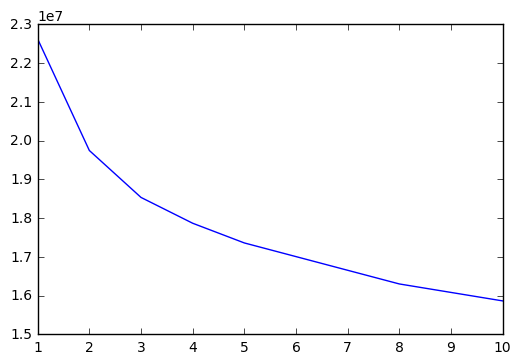

In [9]:
import matplotlib.pyplot as plt
plt.plot(Ks, Costs)
plt.show()

### C.根据各时段红岭北路上的出租车数量及即时速度，估计出整条路上汽车的平均速度

In [1]:
%matplotlib inline
import os
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
vlr = pd.read_csv('/mnt/hgfs/share/Final/I.FINAL-taxi/C.用经纬度，根据某时段某路上车数及即时速度，估计出整条路上汽车的平均速度/tvlr.csv',\
                  names=['Time', 'cNum', 'V', 'weekend', 'avgV'])

vlr.describe(include='all')

,Time,cNum,V,weekend,avgV
count,133082.000000,133082.000000,133082.000000,133082.000000,133082.000000
mean,12.027682,16.376174,25.929367,0.219361,15.369765
std,6.807519,6.047405,16.217447,0.413815,3.389650
min,0.000000,1.000000,1.000000,0.000000,9.645197
25%,7.000000,12.000000,13.000000,0.000000,12.397583
50%,12.000000,16.000000,24.000000,0.000000,14.906400
75%,17.000000,20.000000,37.000000,0.000000,18.551937
max,23.000000,45.000000,104.000000,1.000000,25.446000


In [3]:
#更改变量类型
vlr['hh'] = vlr['Time'].astype('category', categories=\
                               [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23], ordered=True)
vlr['wk'] = vlr['weekend'].astype('category', categories=[0,1], ordered=False)

#### 相关分析
散点图

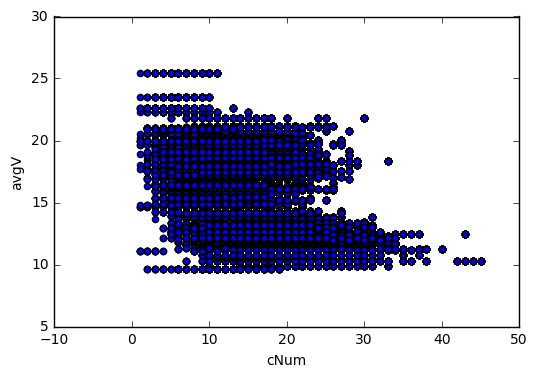

In [4]:
vlr.plot('cNum', 'avgV', kind='scatter')

#### 大致呈负相关

In [5]:
print vlr[['cNum', 'avgV']].corr(method='pearson')

          cNum      avgV
cNum  1.000000 -0.471627
avgV -0.471627  1.000000


#### 线性回归

In [6]:
vlm_s = ols('avgV ~ cNum', data=vlr).fit()
vlm_s.params

Intercept    19.698859
cNum         -0.264353
dtype: float64

In [7]:
vlm_s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   avgV   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                 3.807e+04
Date:                Sun, 29 Jan 2017   Prob (F-statistic):               0.00
Time:                        00:58:40   Log-Likelihood:            -3.3455e+05
No. Observations:              133082   AIC:                         6.691e+05
Df Residuals:                  133080   BIC:                         6.691e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     19.6989      0.024    832.858      0.000        19.653    19.745
cNum          -0.2644      0.001   -195.113      0.000        -0.267    -0.262
==============================================================================
Omnibus:                     9361.227   Durbin-Watson:                   0.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4528.469
Skew:                           0.273   Prob(JB):                         0.00
Kurtosis:                       2.279   Cond. No.                         50.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 多元线性回归

In [8]:
vlm_m = ols('avgV ~ hh + cNum + V + wk + cNum*hh', data=vlr).fit()
vlm_m.params

Intercept        19.447102
hh[T.1]          -0.514156
hh[T.2]          -1.452062
hh[T.3]          -1.115097
hh[T.4]          -0.110153
hh[T.5]           3.153014
hh[T.6]           0.273346
hh[T.7]          -1.672136
hh[T.8]          -4.206878
hh[T.9]          -5.576066
hh[T.10]         -5.739615
hh[T.11]         -7.530608
hh[T.12]         -6.406520
hh[T.13]         -5.599786
hh[T.14]         -6.609079
hh[T.15]         -7.742921
hh[T.16]         -7.704232
hh[T.17]         -7.681073
hh[T.18]         -6.504217
hh[T.19]         -4.622346
hh[T.20]         -2.545579
hh[T.21]         -1.183623
hh[T.22]         -0.272743
hh[T.23]         -0.320053
wk[T.1]           0.474739
cNum             -0.034659
cNum:hh[T.1]     -0.004691
cNum:hh[T.2]      0.098787
cNum:hh[T.3]      0.062863
cNum:hh[T.4]     -0.135010
cNum:hh[T.5]     -0.339948
cNum:hh[T.6]     -0.018211
cNum:hh[T.7]     -0.052557
cNum:hh[T.8]     -0.024630
cNum:hh[T.9]      0.006658
cNum:hh[T.10]    -0.011271
cNum:hh[T.11]     0.038986
c

In [9]:
vlm_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   avgV   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                 1.916e+04
Date:                Sun, 29 Jan 2017   Prob (F-statistic):               0.00
Time:                        00:58:52   Log-Likelihood:            -2.1244e+05
No. Observations:              133082   AIC:                         4.250e+05
Df Residuals:                  133032   BIC:                         4.255e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        19.4471      0.062    315.997      0.000        19.326    19.568
hh[T.1]          -0.5142      0.085     -6.029      0.000        -0.681    -0.347
hh[T.2]          -1.4521      0.088    -16.580      0.000        -1.624    -1.280
hh[T.3]          -1.1151      0.090    -12.377      0.000        -1.292    -0.939
hh[T.4]          -0.1102      0.090     -1.218      0.223        -0.287     0.067
hh[T.5]           3.1530      0.090     35.199      0.000         2.977     3.329
hh[T.6]           0.2733      0.087      3.139      0.002         0.103     0.444
hh[T.7]          -1.6721      0.082    -20.327      0.000        -1.833    -1.511
hh[T.8]          -4.2069      0.083    -50.752      0.000        -4.369    -4.044
hh[T.9]          -5.5761      0.084    -66.215      0.000        -5.741    -5.411
hh[T.10]         -5.7396      0.085    -67.435      0.000        -5.906    -5.573
hh[T.11]         -7.5306      0.086    -87.668      0.000        -7.699    -7.362
hh[T.12]         -6.4065      0.086    -74.426      0.000        -6.575    -6.238
hh[T.13]         -5.5998      0.088    -63.875      0.000        -5.772    -5.428
hh[T.14]         -6.6091      0.083    -79.835      0.000        -6.771    -6.447
hh[T.15]         -7.7429      0.080    -96.768      0.000        -7.900    -7.586
hh[T.16]         -7.7042      0.086    -89.089      0.000        -7.874    -7.535
hh[T.17]         -7.6811      0.087    -88.054      0.000        -7.852    -7.510
hh[T.18]         -6.5042      0.079    -81.895      0.000        -6.660    -6.349
hh[T.19]         -4.6223      0.090    -51.491      0.000        -4.798    -4.446
hh[T.20]         -2.5456      0.084    -30.241      0.000        -2.711    -2.381
hh[T.21]         -1.1836      0.084    -14.170      0.000        -1.347    -1.020
hh[T.22]         -0.2727      0.084     -3.229      0.001        -0.438    -0.107
hh[T.23]         -0.3201      0.090     -3.575      0.000        -0.496    -0.145
wk[T.1]           0.4747      0.008     58.502      0.000         0.459     0.491
cNum             -0.0347      0.004     -9.573      0.000        -0.042    -0.028
cNum:hh[T.1]     -0.0047      0.005     -0.888      0.374        -0.015     0.006
cNum:hh[T.2]      0.0988      0.006     16.354      0.000         0.087     0.111
cNum:hh[T.3]      0.0629      0.008      8.333      0.000         0.048     0.078
cNum:hh[T.4]     -0.1350      0.009    -15.316      0.000        -0.152    -0.118
cNum:hh[T.5]     -0.3399      0.009    -36.819      0.000        -0.358    -0.322
cNum:hh[T.6]     -0.0182      0.008     -2.291      0.022        -0.034    -0.003
cNum:hh[T.7]     -0.0526      0.006     -9.503      0.000        -0.063    -0.042
cNum:hh[T.8]     -0.0246      0.005     -4.864      0.000        -0.035    -0.015
cNum:hh[T.9]      0.0067      0.005      1.310   

In [10]:
?vlm_m.predict()

#### 线性回归的诊断
#### 残差分析

In [21]:
vlr = vlr.dropna(axis=0, how='any')
ana1 = ols('avgV ~ cNum', vlr).fit()
ana1.summary()

   Time  cNum   V  weekend       avgV hh wk  Pred_avgV  resid_avgV
0     0    15  12        0  18.742605  0  0  15.733561    3.009044
1     0    15  18        0  18.742605  0  0  15.733561    3.009044
2     0    15  20        0  18.742605  0  0  15.733561    3.009044
3     0    15  21        0  18.742605  0  0  15.733561    3.009044
4     0    15  24        0  18.742605  0  0  15.733561    3.009044


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   avgV   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                 3.807e+04
Date:                Thu, 26 Jan 2017   Prob (F-statistic):               0.00
Time:                        21:31:49   Log-Likelihood:            -3.3455e+05
No. Observations:              133082   AIC:                         6.691e+05
Df Residuals:                  133080   BIC:                         6.691e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     19.6989      0.024    832.858      0.000        19.653    19.745
cNum          -0.2644      0.001   -195.113      0.000        -0.267    -0.262
==============================================================================
Omnibus:                     9361.227   Durbin-Watson:                   0.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4528.469
Skew:                           0.273   Prob(JB):                         0.00
Kurtosis:                       2.279   Cond. No.                         50.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

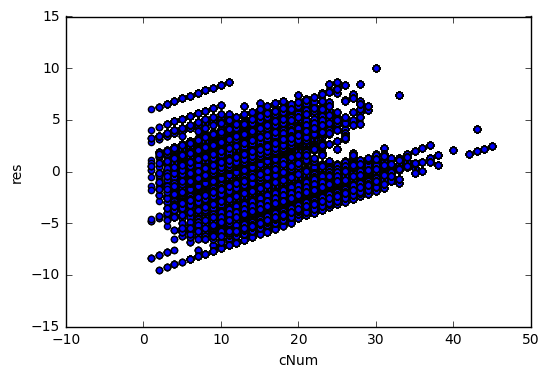

In [24]:
vlr['Pred'] = ana1.predict(vlr)
vlr['res'] = ana1.resid
vlr.plot('cNum', 'res',kind='scatter')

In [25]:
vlr.head()

,Time,cNum,V,weekend,avgV,hh,wk,Pred,res
0,0,15,12,0,18.742605,0,0,15.733561,3.009044
1,0,15,18,0,18.742605,0,0,15.733561,3.009044
2,0,15,20,0,18.742605,0,0,15.733561,3.009044
3,0,15,21,0,18.742605,0,0,15.733561,3.009044
4,0,15,24,0,18.742605,0,0,15.733561,3.009044


#### 多重共线性分析

In [30]:
vlr.columns

Index([u'Time', u'cNum', u'V', u'weekend', u'avgV', u'hh', u'wk', u'Pred',
       u'res'],
      dtype='object')

In [25]:
ana5 = ols('avgV ~ hh + cNum + V + wk + cNum*hh', vlr).fit()
print ana5.summary()
print ana5.mse_resid

                            OLS Regression Results                            
Dep. Variable:                   avgV   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                 1.916e+04
Date:                Thu, 26 Jan 2017   Prob (F-statistic):               0.00
Time:                        21:36:13   Log-Likelihood:            -2.1244e+05
No. Observations:              133082   AIC:                         4.250e+05
Df Residuals:                  133032   BIC:                         4.255e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        19.4471      0.062    315.997

In [28]:
print vlr[['cNum', 'V']].corr()

          cNum         V
cNum  1.000000 -0.099276
V    -0.099276  1.000000


In [29]:
#方差膨胀因子
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_exog = np.array(vlr[['cNum','V']])
for i in range(2):
    print variance_inflation_factor(vif_exog, i)

2.524479294
2.524479294


### E. DBSCAN

#### DBSCAN坐标聚类

In [1]:
#2维的坐标数据：
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
%matplotlib inline

In [2]:
# 每个弧度的地球球面距离
kms_per_radian = 6371.0088

In [36]:
df0 = pd.read_csv('/mnt/hgfs/share/Final/I.FINAL-taxi/D.DBSCAN聚类上下车点/tdb0_1w.csv', names=['lon', 'lat'], encoding='utf-8')
df1 = pd.read_csv('/mnt/hgfs/share/Final/I.FINAL-taxi/D.DBSCAN聚类上下车点/tdb1_1w.csv', names=['lon', 'lat'], encoding='utf-8')

print df0.head()
print df1.tail()

          lon        lat
0  114.050230  22.602966
1  114.040820  22.524366
2  113.903450  22.561533
3  113.875084  22.552717
4  113.894066  22.584917
             lon        lat
9995  114.010400  22.536850
9996  114.114900  22.589933
9997  114.107185  22.573683
9998  113.892260  22.565890
9999  114.024216  22.531317


In [37]:
coords0 = df0.as_matrix(columns=['lon', 'lat'])
coords1 = df1.as_matrix(columns=['lon', 'lat'])

### 计算DBSCAN

  - `eps` 每个点的计算半径
  - `min_samples` 是最小的样本大小

In [47]:
# 半径设为0.2KM, 转化为弧度
epsilon = 0.2 / kms_per_radian

#### 下车点的DBSCAN聚类模型

In [18]:
start_time = time.time()
db0 = DBSCAN(eps=epsilon, min_samples=100, algorithm='ball_tree', metric='haversine').fit(np.radians(coords0))
cluster_labels0 = db0.labels_

# 簇数目
num_clusters0 = len(set(cluster_labels0))

# 打印结果
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(df0), num_clusters0, 100*(1 - float(num_clusters0) / len(df0)), time.time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords0, cluster_labels0)))

Clustered 10,000 points down to 6 clusters, for 99.9% compression in 2.03 seconds
Silhouette coefficient: 0.041


In [22]:
# 把簇转化为Pandas Serie 
clusters0 = pd.Series([coords0[cluster_labels0==n] for n in range(num_clusters0)])[:-1]
clusters0

0    [[114.04082, 22.524366], [114.091286, 22.54716...
1    [[113.894066, 22.584917], [113.89553, 22.56638...
2    [[113.92337, 22.522432], [113.918816, 22.52833...
3    [[114.02333, 22.527884], [114.020134, 22.54156...
4    [[113.81617, 22.647066], [113.81478, 22.649418...
dtype: object

In [24]:
db0

DBSCAN(algorithm='ball_tree', eps=7.84805068861e-05, leaf_size=30,
    metric='haversine', min_samples=100, p=None, random_state=None)

#### 上车点的DBSCAN聚类模型

In [50]:
start_time = time.time()
db1 = DBSCAN(eps=epsilon, min_samples=60, algorithm='ball_tree', metric='haversine').fit(np.radians(coords1))
cluster_labels1 = db1.labels_

# 簇数目
num_clusters1 = len(set(cluster_labels1))

# 打印结果
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(df1), num_clusters1, 100*(1 - float(num_clusters1) / len(df1)), time.time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords1, cluster_labels1)))

Clustered 10,000 points down to 13 clusters, for 99.9% compression in 1.60 seconds
Silhouette coefficient: -0.235


In [53]:
# 把簇转化为Pandas Serie 
clusters1 = pd.Series([coords1[cluster_labels1==n] for n in range(num_clusters1)])[:-1]
clusters1

0     [[113.81648, 22.646784], [113.81602, 22.646982...
1     [[114.06786, 22.523867], [114.06765, 22.523884...
2     [[114.12965, 22.547684], [114.11075, 22.544617...
3     [[114.04795, 22.53745], [114.04775, 22.537733]...
4     [[114.08305, 22.554182], [114.0844, 22.545668]...
5     [[114.09035, 22.543367], [114.09237, 22.54325]...
6     [[114.077065, 22.536533], [114.0792, 22.538883...
7     [[114.0593, 22.520067], [114.05957, 22.5315], ...
8     [[114.0631, 22.53985], [114.06398, 22.532316],...
9     [[114.056, 22.537867], [114.05808, 22.535982],...
10    [[114.10402, 22.556], [114.10345, 22.5529], [1...
11    [[114.1012, 22.547567], [114.09938, 22.5423], ...
dtype: object

In [52]:
db1

DBSCAN(algorithm='ball_tree', eps=3.13922027545e-05, leaf_size=30,
    metric='haversine', min_samples=60, p=None, random_state=None)

### 找出每个簇中离中心点最近的点

In [54]:
def get_centermost_point(cluster):
    if len(cluster) != 0:
        centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
        centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
        return tuple(centermost_point)

#### 下车点的中心点

In [26]:
centermost_points0 = clusters0.map(get_centermost_point)
centermost_points0

0     (114.09123, 22.546967)
1      (113.8949, 22.568233)
2    (113.921486, 22.526684)
3    (114.022415, 22.534582)
4      (113.81596, 22.64865)
dtype: object

In [28]:
# unzip最近中心点的list (lat, lon) 的tuple到分开的list
lons0, lats0 = zip(*centermost_points0)

# 创建一个新的df来保存每一个簇的代表点
rep_points0 = pd.DataFrame({'lon':lons0, 'lat':lats0})
rep_points0

,lat,lon
0,22.546967,114.091230
1,22.568233,113.894900
2,22.526684,113.921486
3,22.534582,114.022415
4,22.648650,113.815960


In [30]:
# 从原始的数据集提出经纬度和代表点的经纬度相匹配的row，以获取原始数据集里更详细的信息
rs0 = rep_points0.apply(lambda row: df0[(df0['lat']==row['lat']) & (df0['lon']==row['lon'])].iloc[0], axis=1)
rs0.to_csv('db0_centroids.csv', encoding='utf-8')
rs0

,lon,lat
0,114.091230,22.546967
1,113.894900,22.568233
2,113.921486,22.526684
3,114.022415,22.534582
4,113.815960,22.648650


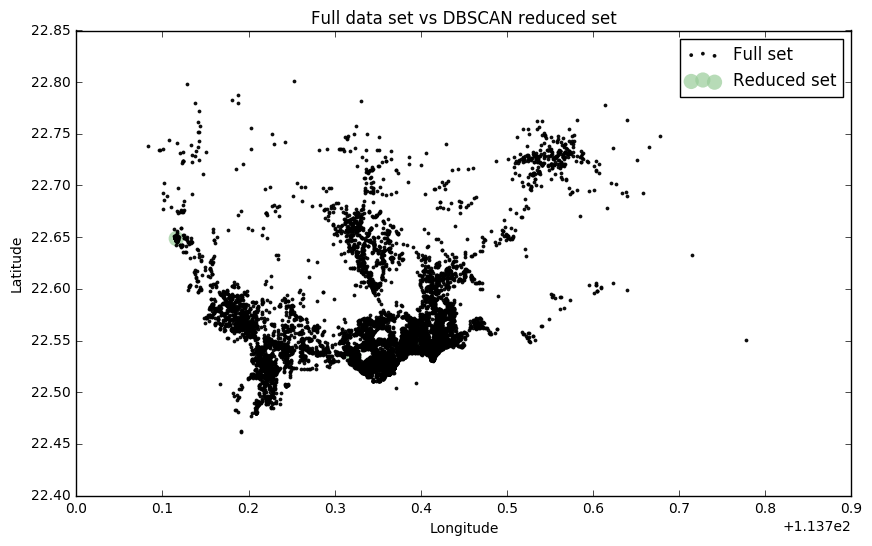

In [33]:
# 图示聚类结果和原始点的对比
rs_scatter0 = ax.scatter(rs0['lon'], rs0['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter0 = ax.scatter(df0['lon'], df0['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter0, rs_scatter0], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

#### 上车点的中心点

In [55]:
centermost_points1 = clusters1.map(get_centermost_point)
centermost_points1

0      (113.81568, 22.648533)
1      (114.06778, 22.524233)
2        (114.116, 22.543234)
3      (114.04869, 22.537447)
4      (114.08225, 22.545834)
5      (114.09098, 22.543266)
6       (114.0779, 22.536734)
7     (114.060135, 22.523684)
8      (114.06327, 22.535816)
9      (114.05658, 22.537117)
10    (114.104515, 22.553482)
11      (114.100784, 22.5442)
dtype: object

In [56]:
lons1, lats1 = zip(*centermost_points1)

# 创建一个新的数据框来保存每一个簇的代表点
rep_points1 = pd.DataFrame({'lon':lons1, 'lat':lats1})
rep_points1

,lat,lon
0,22.648533,113.815680
1,22.524233,114.067780
2,22.543234,114.116000
3,22.537447,114.048690
4,22.545834,114.082250
5,22.543266,114.090980
6,22.536734,114.077900
7,22.523684,114.060135
8,22.535816,114.063270
9,22.537117,114.056580


In [57]:
rs1 = rep_points1.apply(lambda row: df1[(df1['lat']==row['lat']) & (df1['lon']==row['lon'])].iloc[0], axis=1)
rs1.to_csv('db1_centroids.csv', encoding='utf-8')
rs1

,lon,lat
0,113.815680,22.648533
1,114.067780,22.524233
2,114.116000,22.543234
3,114.048690,22.537447
4,114.082250,22.545834
5,114.090980,22.543266
6,114.077900,22.536734
7,114.060135,22.523684
8,114.063270,22.535816
9,114.056580,22.537117


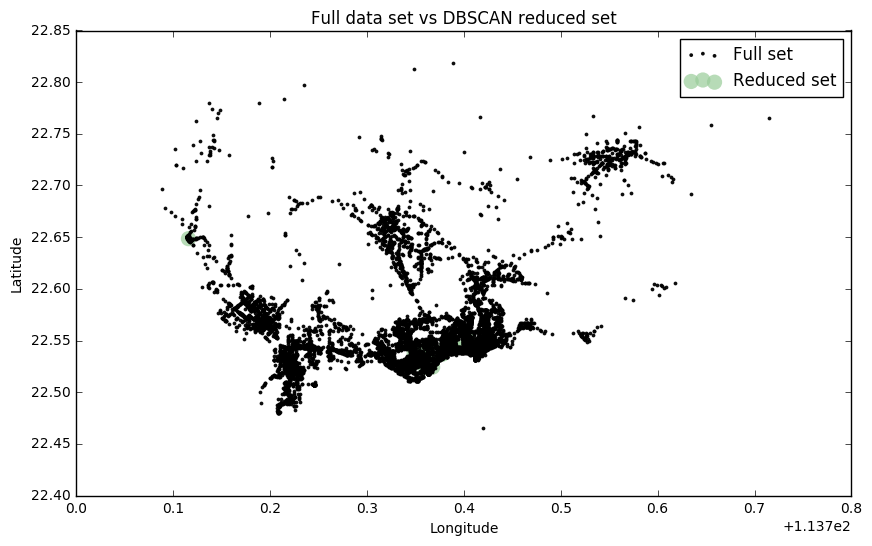

In [58]:
# 图示聚类结果和原始点的对比
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter1 = ax.scatter(rs1['lon'], rs1['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter1 = ax.scatter(df1['lon'], df1['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter1, rs_scatter1], ['Full set', 'Reduced set'], loc='upper right')
plt.show()